<span>
<b>Author:</b> Chenxiang Zhang <br/>
<b>Python version:</b>  3.x <br/>
</span>

## Data Clustering
In this notebook, we are going to analyze the data using clustering algorithms. Firstly we process even further the data by normalization and PCA, then with the prepared data we experiment with different clustering methods, such as center-based, density-based and hierarchical clustering. In the end, we compare quantitatively and qualitatively the results produced by the algorithms.

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
df = pd.read_csv("../../data/profile/vendor_profile_log.csv", sep=',', index_col=0)
df.head()

,unique_ram,revenue_per_unit,revenue_per_day,days
vendor_code,,,,
1,1.778151,2.120849,2.147317,2.864511
2,2.292256,2.171934,2.904020,2.864511
3,2.307496,2.189192,4.030182,1.643453
4,2.004321,2.151190,3.329420,1.431364
5,2.440909,2.218444,3.647152,2.686636


In [3]:
# df.cov()
# pd.DataFrame(X).cov()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Explained Variance of top-2 components:  0.8124984420350405


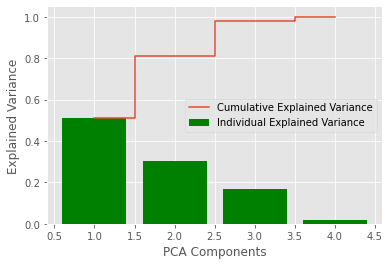

In [5]:
# PCA maximizes the variance and it is sensible to variables with predominant high variance,
# thus we need to normalize the data before the PCA to unit variance.
scaler = StandardScaler()
X = scaler.fit_transform(df)

pca = PCA()
pca.fit(X)

plt.step(range(1, X.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), 
         where='mid', label='Cumulative Explained Variance')
plt.bar(range(1, X.shape[1] + 1), pca.explained_variance_ratio_, 
        color='g', label='Individual Explained Variance')
plt.ylabel('Explained Variance')
plt.xlabel('PCA Components')
plt.legend()
plt.savefig('../../tex/imgs/clustering_pca_variance.pdf')
plt.savefig('../../tex/imgs/clustering_pca_variance.png')

print("Explained Variance of top-2 components: ", sum(pca.explained_variance_ratio_[:2]))

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_X = pd.DataFrame(X_pca, columns=['Component0', 'Component1'])

In [7]:
# # remove outliers
# X_pca = [x for x in X_pca if x[0] < 2.5 and x[1] < 2.5]
# df_X = pd.DataFrame(X_pca, columns=['Component0', 'Component1'])

In [8]:
# plot function
def plot_silhouette_and_scatter(X, cluster_labels):
    # create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 5)
    best_k = len(set(cluster_labels))

    # silhouette_score is the average value for all the samples.
    # silhouette_sample compute the score for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    y_lower = 10
    for i in range(best_k):
        # Aggregate the silhouette scores for cluster, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / best_k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        # Compute the new y_lower for next plot
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Scatter plot
    ax2.scatter(X[:, 0], X[:, 1], lw=0, c=cluster_labels)

#     centers = clusterer.cluster_centers_
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", s=300)
#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

    plt.xlabel('PCA Component 0')
    plt.ylabel('PCA Component 1')
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data" 
                  "with n_clusters = %d" % best_k))

### Center Based Clustering: K-Means
First of all we want determine the best value of K by plotting SSE and Silhouette score for each different K. The SSE score is the Sum of Squared Error, it measures the cohesion of a cluster, which is the sum of the distance for each point to its cluster center.

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

In [46]:
# check the best K
sse = []
silhouette = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=8)
    kmeans.fit(X_pca)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca, kmeans.labels_))
    
# select the best clustering based on silhouette score
best_k = np.argmax(silhouette)+2

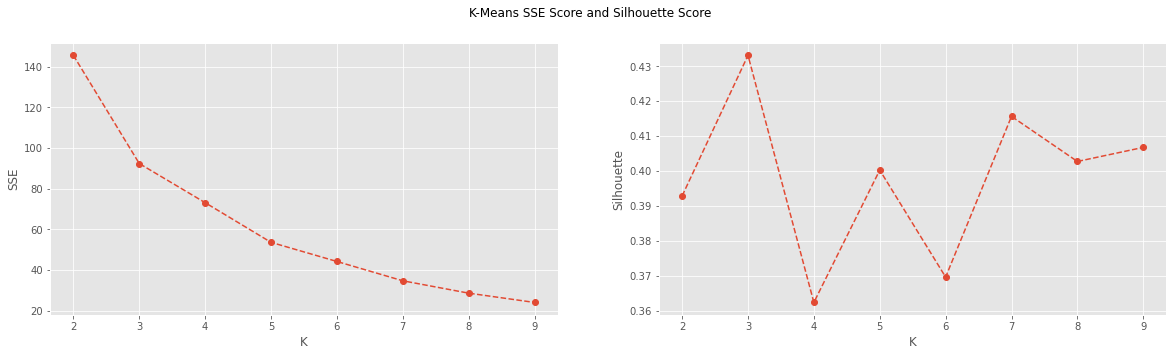

In [47]:
# plot the SSE and Silhouette evaluation scores
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.plot(range(2, len(sse)+2), sse, marker='o', linestyle='--')
plt.xlabel('K')
plt.ylabel('SSE')

plt.subplot2grid(fig_dims, (0, 1))
plt.plot(range(2, len(silhouette)+2), silhouette, marker='o', linestyle='--')
plt.xlabel('K')
plt.ylabel('Silhouette')

plt.suptitle('K-Means SSE Score and Silhouette Score')
plt.savefig('../../tex/imgs/clustering_kmeans_score.pdf')
plt.savefig('../../tex/imgs/clustering_kmeans_score.png')

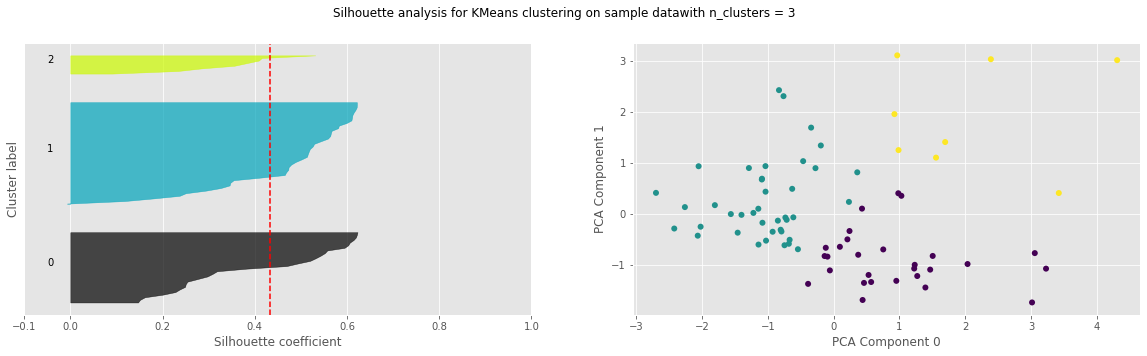

In [48]:
kmeans = KMeans(n_clusters=best_k, random_state=4)
kmeans.fit(X_pca)
plot_silhouette_and_scatter(X_pca, kmeans.labels_)

plt.savefig('../../tex/imgs/clustering_kmeans_plot.pdf')
plt.savefig('../../tex/imgs/clustering_kmeans_plot.png')

In [13]:
from sklearn import metrics
print('SSE: \t\t', kmeans.inertia_)
print('Silhouette: \t', silhouette_score(X_pca, kmeans.labels_))
print('Separation: \t', metrics.davies_bouldin_score(X_pca, kmeans.labels_))

SSE: 		 53.117579018658
Silhouette: 	 0.43773130614811473
Separation: 	 0.7471412599770664


In [49]:
# post process the clusters and combine cluster 2 and cluster 0
# create new dataframe containing the vendor profile
# labels (?): green = 1, yellow = 2 purple = 0
df_kmeans = df.copy()
df_kmeans['type'] = kmeans.labels_
df_kmeans['type'] = df_kmeans['type'].map({0: 'small', 1: 'big', 2: 'small'})
df_kmeans.to_csv('../../data/profile/vendor_profile_kmeans.csv', sep=',')
df_kmeans

,unique_ram,revenue_per_unit,revenue_per_day,days,type
vendor_code,,,,,
1,1.778151,2.120849,2.147317,2.864511,small
2,2.292256,2.171934,2.904020,2.864511,small
3,2.307496,2.189192,4.030182,1.643453,big
4,2.004321,2.151190,3.329420,1.431364,small
5,2.440909,2.218444,3.647152,2.686636,big
...,...,...,...,...,...
77,1.176091,2.063027,1.079923,2.863917,small
78,2.107210,2.040341,2.787765,2.864511,small
79,2.431364,2.185288,3.206421,2.864511,big


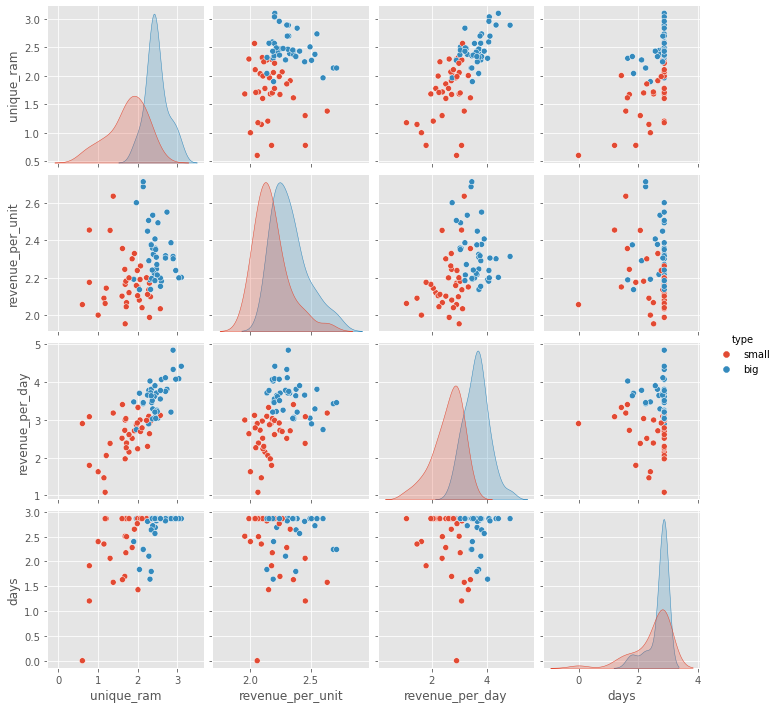

In [50]:
# save the kmeans vendor profile
sns.pairplot(df_kmeans, hue='type', diag_kind='kde')
plt.savefig('../../tex/imgs/clustering_kmeans_pair_plot.pdf')
plt.savefig('../../tex/imgs/clustering_kmeans_pair_plot.png')

### Density Based Clustering: DBSCAN
The DBSCAN is controlled by two parameters value _Eps_ and _MinPts_.
Empirical best parameter for MinPts reported in the paper during the experiments is 4, a value k > 4 do not significantly differ from 4-dist graph but requires more computation. The distance from a point to its neighboars can be calculated using the sklearn function NearestNeighbors. The knn method returns two arrays: distances and indices. The distances indicates the distance from the point to its k-nn and indices its indice. The sharp change in the distance corresponds to the optimal value of Eps.

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

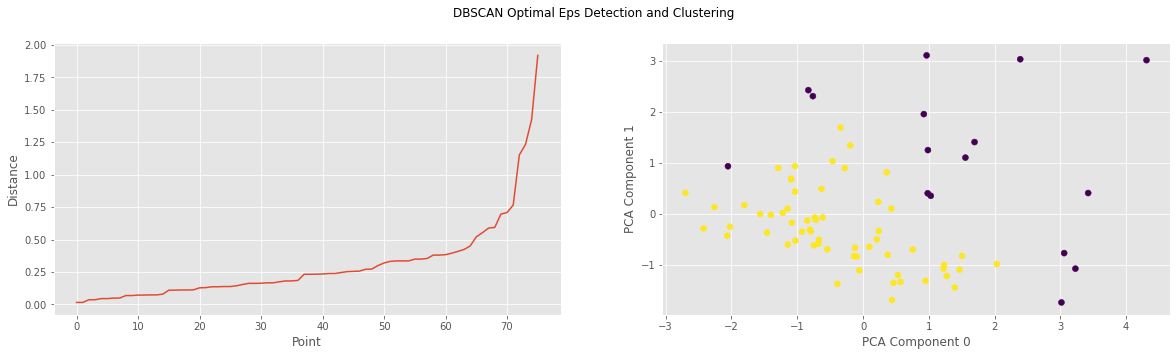

In [17]:
knn = NearestNeighbors(n_neighbors=4)
nbrs = knn.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)
distances = np.sort(distances, axis=0)[:, 1]

# Plot the distance to detect the sharp change
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.plot(distances)
plt.xlabel('Point')
plt.ylabel('Distance')

# Plot the DBSCAN result with the best eps
plt.subplot2grid(fig_dims, (0, 1))
dbscan = DBSCAN(eps=0.6, min_samples=4)
dbscan.fit(X_pca)
plt.scatter(df_X['Component0'], df_X['Component1'],c=dbscan.labels_)
plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')

plt.suptitle('DBSCAN Optimal Eps Detection and Clustering')
plt.savefig('../../tex/imgs/clustering_dbscan_plot.pdf')
plt.savefig('../../tex/imgs/clustering_dbscan_plot.png')

In [18]:
print('Silhouette: \t', silhouette_score(X_pca, dbscan.labels_))
print('Separation: \t', metrics.davies_bouldin_score(X_pca, dbscan.labels_))

Silhouette: 	 0.4095093684853711
Separation: 	 1.2873092736451028


In [19]:
# create new dataframe containing the vendor profile
df_dbscan = df.copy()
df_dbscan['type'] = dbscan.labels_
df_dbscan['type'] = df_dbscan['type'].map({0: 'small', -1: 'big'})
df_dbscan.to_csv('../../data/profile/vendor_profile_dbscan.csv', sep=',')
df_dbscan

,unique_ram,revenue_per_unit,revenue_per_day,days,type
vendor_code,,,,,
1,1.778151,2.120849,2.147317,2.864511,small
2,2.292256,2.171934,2.904020,2.864511,small
3,2.307496,2.189192,4.030182,1.643453,small
4,2.004321,2.151190,3.329420,1.431364,big
5,2.440909,2.218444,3.647152,2.686636,small
...,...,...,...,...,...
77,1.176091,2.063027,1.079923,2.863917,big
78,2.107210,2.040341,2.787765,2.864511,small
79,2.431364,2.185288,3.206421,2.864511,small


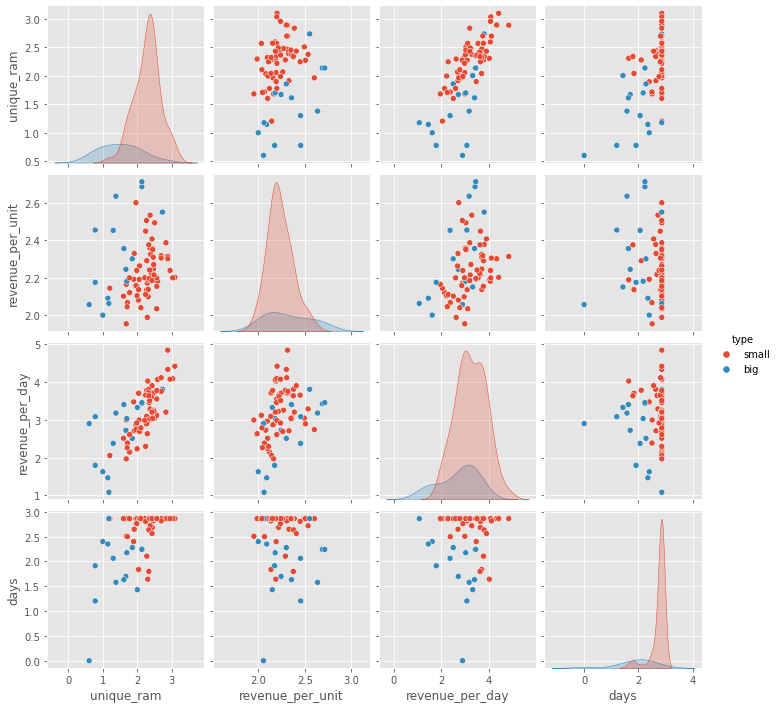

In [20]:
# save the dbscan vendor profile
sns.pairplot(df_dbscan, hue='type', diag_kind='kde')
plt.savefig('../../tex/imgs/clustering_dbscan_pair_plot.pdf')
plt.savefig('../../tex/imgs/clustering_dbscan_pair_plot.png')

### Agglomerative Hierarchical Clustering
Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram).

The idea is to compute a proximity matrix, then iteratively merge the closest two clusters and update the matrix until only one cluster remains. There are different metrics used to compute the proximate, these are called linkage criterion:
- Single link (min): compute the distance between the two closest points in two clusters
    - pro: handles non-elliptical shapes
    - con: sensitive to noise and outliers
- Complete link (max): compute the distance between the two furthest points in two clusters
    - pro: less susceptible to noise and outliers
    - con: can break large clusters, biased towards globular clusters
- Average link: compute the average distance between all points of two clusters
    - pro: less susceptible to noise and outliers
    - con: biased towards globular clusters
- Ward link: minimizes the squared error when two clusters are merged
    - pro: less susceptible to noise and outliers
    - con: biased towards globular clusters

In [21]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

In [22]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [23]:
def plot_dendrogram(model, **kwargs):
    """Create linkage matrix and then plot the dendrogram"""
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

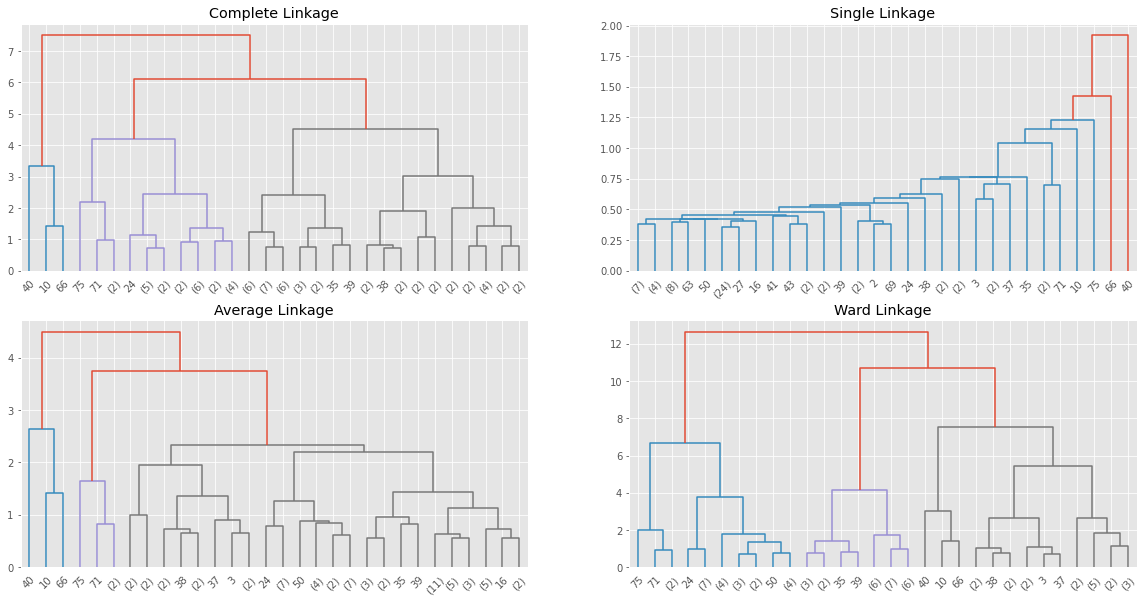

In [24]:
# Run and plot all the hierarchical agglomerative linking methods
fig = plt.figure(figsize=(20, 10)) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Complete linking
plt.subplot2grid(fig_dims, (0, 0))
complete_link = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
complete_link.fit(df_X)
plt.title('Complete Linkage')
plot_dendrogram(complete_link, truncate_mode='lastp')

# Single linking
plt.subplot2grid(fig_dims, (0, 1))
single_link = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')
single_link.fit(df_X)
plt.title('Single Linkage')
plot_dendrogram(single_link, truncate_mode='lastp')

# Average linking
plt.subplot2grid(fig_dims, (1, 0))
average_link = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')
average_link.fit(df_X)
plt.title('Average Linkage')
plot_dendrogram(average_link, truncate_mode='lastp')

# Ward linking
plt.subplot2grid(fig_dims, (1, 1))
ward_link = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
ward_link.fit(df_X)
plt.title('Ward Linkage')
plot_dendrogram(ward_link, truncate_mode='lastp')

plt.savefig('../../tex/imgs/clustering_hierarchical_all.pdf')
plt.savefig('../../tex/imgs/clustering_hierarchical_all.png')

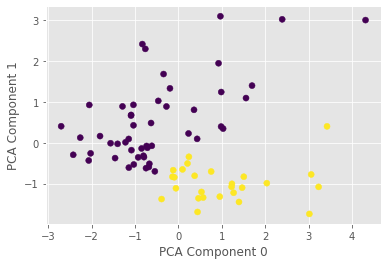

In [25]:
# The best cluster among the linking methods is the ward.
# We force the ward linkage to output 2 clusters and plot
ward_link = AgglomerativeClustering(distance_threshold=None, n_clusters=2, linkage='ward')
ward_link.fit(df_X)
plt.scatter(df_X['Component0'], df_X['Component1'], c=ward_link.labels_)
plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')

plt.savefig('../../tex/imgs/clustering_hierarchical_ward.pdf')
plt.savefig('../../tex/imgs/clustering_hierarchical_ward.png')

In [26]:
print('Silhouette: \t', silhouette_score(X_pca, ward_link.labels_))
print('Separation: \t', metrics.davies_bouldin_score(X_pca, ward_link.labels_))

Silhouette: 	 0.3463209626566939
Separation: 	 1.076340012916633


In [27]:
# create new dataframe containing the vendor profile
# labels: yellow = 1, purple = 0
df_ward = df.copy()
df_ward['type'] = ward_link.labels_
df_ward['type'] = df_ward['type'].map({0: 'small', 1: 'big'})
df_ward.to_csv('../../data/profile/vendor_profile_ward.csv', sep=',')
df_ward

,unique_ram,revenue_per_unit,revenue_per_day,days,type
vendor_code,,,,,
1,1.778151,2.120849,2.147317,2.864511,big
2,2.292256,2.171934,2.904020,2.864511,big
3,2.307496,2.189192,4.030182,1.643453,small
4,2.004321,2.151190,3.329420,1.431364,small
5,2.440909,2.218444,3.647152,2.686636,small
...,...,...,...,...,...
77,1.176091,2.063027,1.079923,2.863917,big
78,2.107210,2.040341,2.787765,2.864511,big
79,2.431364,2.185288,3.206421,2.864511,small


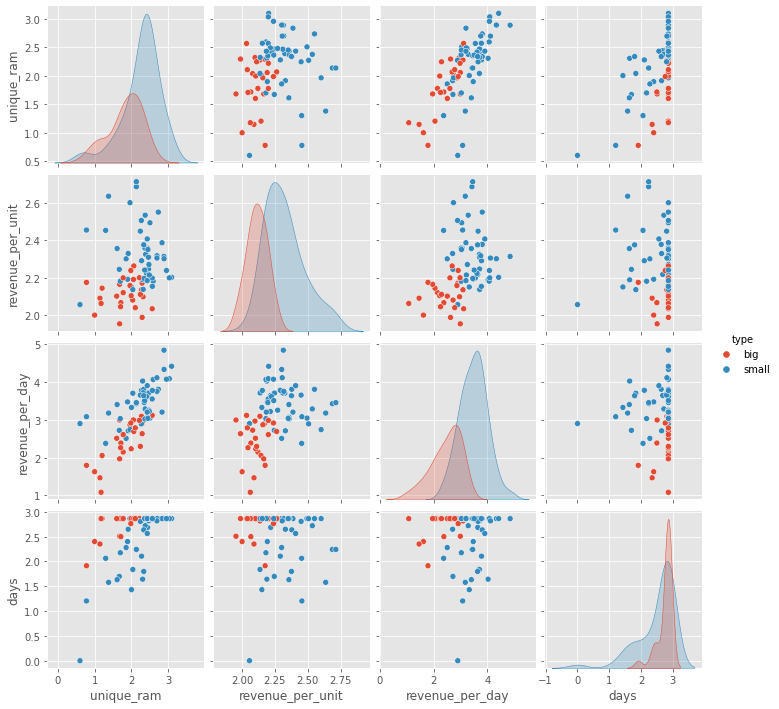

In [28]:
# save the dbscan vendor profile
sns.pairplot(df_ward, hue='type', diag_kind='kde')
plt.savefig('../../tex/imgs/clustering_hierarchical_ward_pair_plot.pdf')
plt.savefig('../../tex/imgs/clustering_hierarchical_ward_pair_plot.png')

In [29]:
df.sort_values(by=['revenue_per_day'])

,unique_ram,revenue_per_unit,revenue_per_day,days
vendor_code,,,,
77,1.176091,2.063027,1.079923,2.863917
66,1.146128,2.091103,1.463196,2.352183
61,1.000000,2.000614,1.624519,2.401401
81,0.778151,2.175836,1.793501,1.913814
29,1.681241,2.165335,1.966405,2.864511
...,...,...,...,...
50,3.035029,2.199996,4.091923,2.864511
63,2.697229,2.305917,4.117559,2.818226
45,2.891537,2.302098,4.338090,2.864511


In [30]:
# df_ward[df_ward['type']=='small']

### Affinity Propagation
https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation
Reference: Brendan J. Frey and Delbert Dueck, “Clustering by Passing Messages Between Data Points”, Science Feb. 2007



In [31]:
from sklearn.cluster import AffinityPropagation

In [32]:
aff_prop = AffinityPropagation(preference=-50, random_state=0).fit(X_pca)
cluster_centers_indices = aff_prop.cluster_centers_indices_

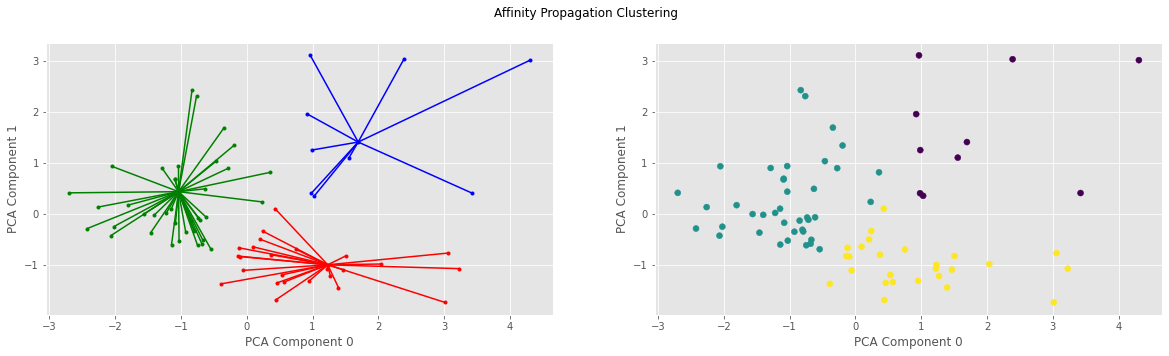

In [33]:
# Plot the affinity propagation
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
for k, col in zip(range(len(aff_prop.labels_)), 'bgr'):
    class_members = aff_prop.labels_ == k
    cluster_center = X_pca[cluster_centers_indices[k]]
    plt.plot(X_pca[class_members, 0], X_pca[class_members, 1], col + '.')
    for x in X_pca[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)
plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')
        
# Plot the clustering labels
plt.subplot2grid(fig_dims, (0, 1))
plt.scatter(df_X['Component0'], df_X['Component1'], c=aff_prop.labels_)
plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')

plt.suptitle('Affinity Propagation Clustering')
plt.savefig('../../tex/imgs/clustering_affinity.pdf')
plt.savefig('../../tex/imgs/clustering_affinity.png')

In [34]:
print('Silhouette: \t', silhouette_score(X_pca, aff_prop.labels_))
print('Separation: \t', metrics.davies_bouldin_score(X_pca, aff_prop.labels_))

Silhouette: 	 0.42684864334809486
Separation: 	 0.8116537780712657


In [35]:
# create new dataframe containing the vendor profile
# labels: yellow = 2, green = 1, purple = 0
df_aff = df.copy()
df_aff['type'] = aff_prop.labels_
df_aff['type'] = df_aff['type'].map({0: 'big', 1: 'small', 2: 'big'})
df_aff.to_csv('../../data/profile/vendor_profile_affinity.csv', sep=',')
df_aff

,unique_ram,revenue_per_unit,revenue_per_day,days,type
vendor_code,,,,,
1,1.778151,2.120849,2.147317,2.864511,big
2,2.292256,2.171934,2.904020,2.864511,big
3,2.307496,2.189192,4.030182,1.643453,small
4,2.004321,2.151190,3.329420,1.431364,big
5,2.440909,2.218444,3.647152,2.686636,small
...,...,...,...,...,...
77,1.176091,2.063027,1.079923,2.863917,big
78,2.107210,2.040341,2.787765,2.864511,big
79,2.431364,2.185288,3.206421,2.864511,small


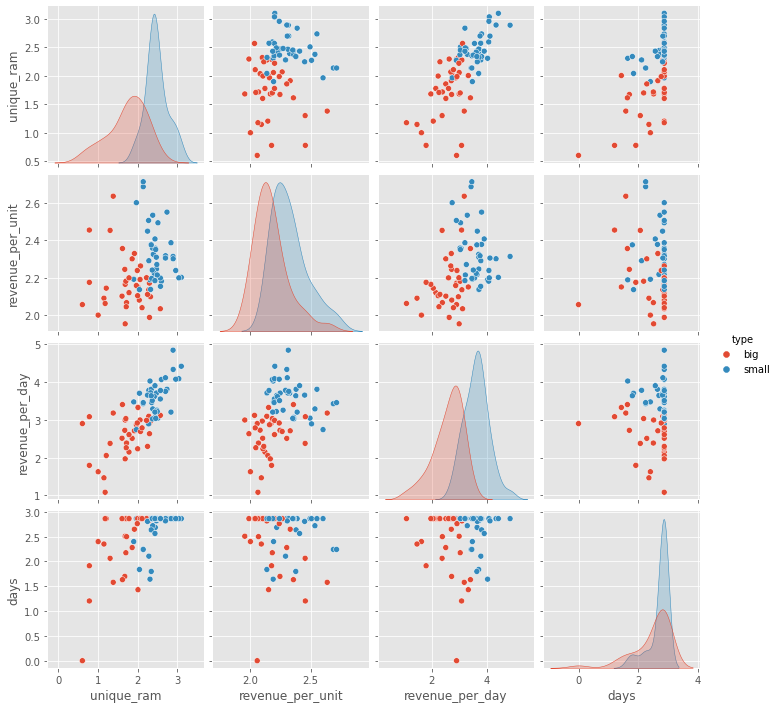

In [36]:
sns.pairplot(df_aff, hue='type', diag_kind='kde')
plt.savefig('../../tex/imgs/clustering_affinity_pair_plot.pdf')
plt.savefig('../../tex/imgs/clustering_affinity_pair_plot.png')

<!-- ### Chosen Clustering Algorithm
The final chosen algorithm is K-Means -->

In [37]:
# kmeans = KMeans(n_clusters=2, random_state=4)
# kmeans.fit(X_pca)
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
# plt.xlabel('PCA Component 0')
# plt.ylabel('PCA Component 1')
# plt.savefig('../../tex/imgs/clustering_kmeans_plot_post.pdf')

In [38]:
# df_final = df.copy()
# df_final['type'] = kmeans.labels_
# df_final['type'] = df_final['type'].map({0: 'big', 1: 'small'})
# df_final.to_csv('../../data/profile/vendor_profile_final.csv', sep=',')
# df_final

In [39]:
# from math import pi
 
# kmeans = KMeans(n_clusters=2, random_state=4)
# kmeans.fit(X)
# centers = scaler.inverse_transform(kmeans.cluster_centers_)
    
# N = len(df.columns)
# ax = plt.subplot(polar=True)

# # What will be the angle of each axis in the plot? 
# # (we divide the plot / number of variable)
# for i in range(0, len(centers)):
#     angles = [n / float(N) * 2 * pi for n in range(N)]
#     values = centers[i].tolist()
#     values += values[:1]
#     angles += angles[:1]
    
#     plt.xticks(angles[:-1], df.columns, size=10) 
#     ax.plot(angles, values)
#     ax.fill(angles, values, 'b', alpha=0.1)
# plt.legend(['big','small'])